<a href="https://colab.research.google.com/github/GDharan10/Dataset_Diabetes_Prediction/blob/main/Diabetes_Prediction_Dataset_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Librarys**

In [2]:
import pandas as pd
import numpy as np

#Connections
from google.colab import drive

#Statistic
from scipy import stats

#Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing
from sklearn.preprocessing import OrdinalEncoder

#Machine Learning
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.cluster import KMeans

# **Connections**

In [3]:
#Google drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading dataset**

In [4]:
#Google drive
file_path = '/content/drive/My Drive/DTM15/Dataset/diabetes_prediction_dataset.csv'
df = pd.read_csv(file_path)

In [5]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# **DataFrame observation**


In [6]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')

In [16]:
# Dependent - diabetes
# Independent - 'gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level'

continuous_columns = ['bmi', 'HbA1c_level', 'blood_glucose_level']
category_columns = ['gender', 'age','hypertension', 'heart_disease', 'smoking_history', 'diabetes']

#Supervised Classification

# **Data cleaning using pandas**


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [8]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [9]:
df.duplicated().sum()

3854

In [10]:
df.drop_duplicates(inplace = True)

# **Hypothesis testing / Statistical analysis**


Continuous - Central Limit Theorem, 1-Tailed Test (one-sample t-test)

Continuous vs. Continuous - Correlation, 2-Tailed Test (two-sample t-test)

Continuous vs. Categorical - ANOVA (Analysis of Variance)

Categorical vs. Categorical - Chi-Square Test

In [11]:
def hypothesisTesting(continuous_columns = [], category_columns = [], sampling_rate = 0.20, sampling_frac=0.05):
  #Central Limit Theorem
  oneContinesColumn_result = {}
  hypothesis_df = pd.DataFrame(columns=df.columns, index=df.columns)
  if continuous_columns:
    samplesize = int(sampling_rate * len(df[continuous_columns[0]]))
    for column in continuous_columns:
      population=df[column].values
      population_mean = population.mean()
      sample_mean=[]
      for i in range(40):
        sample=np.random.choice(population,samplesize)
        sample_mean.append(sample.mean())
      oneContinesColumn_result[column] = {
                                          "Population Mean": population_mean,
                                          "Sample Means": {np.mean(sample_mean)}
                                          }

  #1-Tailed Test
  if continuous_columns:
    samplesize = int(sampling_rate * len(df[continuous_columns[0]]))
    for column in continuous_columns:
      H0_accepted = 0
      H0_rejected = 0
      for i in range(samplesize):
        sample=df[column].sample(frac=sampling_frac)
        t_test,p_value=stats.ttest_1samp(sample,df[column].mean())
        if p_value > 0.5:
          H0_accepted += 1
        else:
          H0_rejected += 1

      if H0_accepted > H0_rejected:
          oneContinesColumn_result[column].update( {
                                            "H0_accepted": H0_accepted,
                                            "H0_rejected": H0_rejected,
                                            "Conclusion": "H0 is accepted, Ha is rejected, There is no significant effect"
                                          } )
          hypothesis_df[column][column] = "There is a relationship"

      else:
          oneContinesColumn_result[column].update( {
                                              "H0_accepted": H0_accepted,
                                              "H0_rejected": H0_rejected,
                                              "Conclusion": "H0 is rejected, Ha is accepted, There is a significant effect"
                                              } )
          hypothesis_df[column][column] = "There is no relationship"


  #2-Tailed Test
  for i in range(len(continuous_columns) - 1):
      column_1 = continuous_columns[i]
      for column_2 in continuous_columns[i+1:]:
        H0_accepted = 0
        H0_rejected = 0
        for i in range(20):
          sample1 = df[column_1].sample(frac=sampling_frac)
          sample2 = df[column_2].sample(frac=sampling_frac)
          t_test, p_value = stats.ttest_ind(sample1, sample2)
          if p_value > 0.5:
            H0_accepted += 1
          else:
            H0_rejected += 1

        if H0_accepted > H0_rejected:
          #H0 is accepted, Ha is rejected, There is no significant effect. "H0_accepted": H0_accepted, "H0_rejected": H0_rejected
          hypothesis_df[column_1][column_2] = "There is a relationship"
          hypothesis_df[column_2][column_1] = "There is a relationship"
        else:
          #H0 is rejected, Ha is accepted, There is a significant effect. "H0_accepted": H0_accepted, "H0_rejected": H0_rejected
            hypothesis_df[column_1][column_2] = "There is no relationship"
            hypothesis_df[column_2][column_1] = "There is no relationship"

  #Chi-Square Test
  if category_columns:
    for i in range(len(category_columns) - 1):
        column_1 = category_columns[i]
        for column_2 in category_columns[i + 1:]:
            data = pd.crosstab(df[column_1], df[column_2])
            observed_values = data.values
            chi2_stat, p_value, _, _ = stats.chi2_contingency(observed_values)

            if p_value > 0.05:
                # H0 is accepted, There is no relationship between two columns we're comparing
                hypothesis_df[column_1][column_2] = "There is no relationship"
                hypothesis_df[column_2][column_1] = "There is no relationship"
            else:
                # H0 is rejected, There is a relationship between two columns we're comparing
                hypothesis_df[column_1][column_2] = "There is a relationship"
                hypothesis_df[column_2][column_1] = "There is a relationship"

  #ANOVA
  if continuous_columns and category_columns:
    for category_column in category_columns:
      for continuous_column in continuous_columns:
        group = df[category_column].unique()
        data = {}
        for i in group:
          data[i]=df[continuous_column][df[category_column]==i]

        f_value, p_value = stats.f_oneway(*[data[i] for i in group])
        if p_value > 0.05:
            # H0 is accepted, There is a relationship between two columns we're comparing
            hypothesis_df[category_column][continuous_column] = "There is a relationship"
            hypothesis_df[continuous_column][category_column] = "There is a relationship"
        else:
            # H0 is rejected, There is no relationship between two columns we're comparing
            hypothesis_df[category_column][continuous_column] = "There is no relationship"
            hypothesis_df[continuous_column][category_column] = "There is no relationship"

  return oneContinesColumn_result, hypothesis_df

# Correlation

In [12]:
df.corr()

<ipython-input-12-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
age,1.000000,0.257305,0.238451,0.344797,0.106719,0.114317,0.264927
hypertension,0.257305,1.000000,0.119982,0.148111,0.081441,0.084834,0.195710
heart_disease,0.238451,0.119982,1.000000,0.061376,0.068140,0.070832,0.170711
bmi,0.344797,0.148111,0.061376,1.000000,0.084423,0.092543,0.214932
HbA1c_level,0.106719,0.081441,0.068140,0.084423,1.000000,0.171615,0.406408
blood_glucose_level,0.114317,0.084834,0.070832,0.092543,0.171615,1.000000,0.424336
diabetes,0.264927,0.195710,0.170711,0.214932,0.406408,0.424336,1.000000


<ipython-input-14-0f52dd28a8b8>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


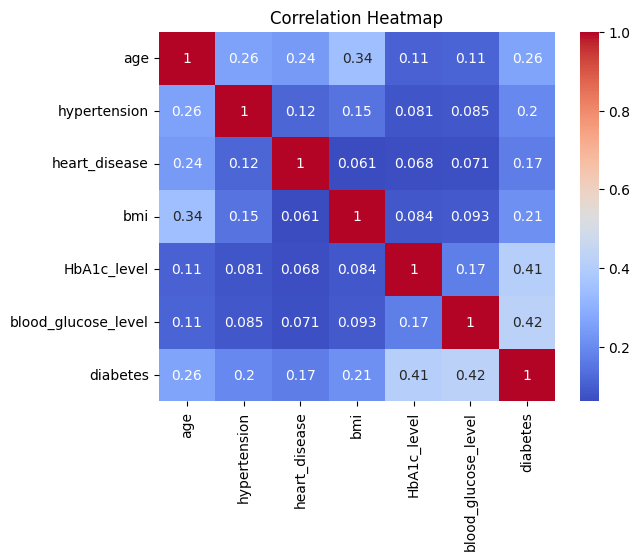

In [14]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# **Result Hypothesis**

In [17]:
ContinesColumn_result, comperativeColumn_result = hypothesisTesting(continuous_columns , category_columns)

In [19]:
ContinesColumn_result_df = pd.DataFrame(ContinesColumn_result)
ContinesColumn_result_df

,bmi,HbA1c_level,blood_glucose_level
Population Mean,27.321461,5.532609,138.218231
Sample Means,{27.318734749596967},{5.532774715273805},{138.16379816943157}
H0_accepted,9817,9914,9903
H0_rejected,9412,9315,9326
Conclusion,"H0 is accepted, Ha is rejected, There is no si...","H0 is accepted, Ha is rejected, There is no si...","H0 is accepted, Ha is rejected, There is no si..."


In [20]:
comperativeColumn_result

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
gender,NaN,There is a relationship,There is a relationship,There is a relationship,There is a relationship,There is no relationship,There is no relationship,There is no relationship,There is a relationship
age,There is a relationship,NaN,There is a relationship,There is a relationship,There is a relationship,There is no relationship,There is no relationship,There is no relationship,There is a relationship
hypertension,There is a relationship,There is a relationship,NaN,There is a relationship,There is a relationship,There is no relationship,There is no relationship,There is no relationship,There is a relationship
heart_disease,There is a relationship,There is a relationship,There is a relationship,NaN,There is a relationship,There is no relationship,There is no relationship,There is no relationship,There is a relationship
smoking_history,There is a relationship,There is a relationship,There is a relationship,There is a relationship,NaN,There is no relationship,There is no relationship,There is no relationship,There is a relationship
bmi,There is no relationship,There is no relationship,There is no relationship,There is no relationship,There is no relationship,There is a relationship,There is no relationship,There is no relationship,There is no relationship
HbA1c_level,There is no relationship,There is no relationship,There is no relationship,There is no relationship,There is no relationship,There is no relationship,There is a relationship,There is no relationship,There is no relationship
blood_glucose_level,There is no relationship,There is no relationship,There is no relationship,There is no relationship,There is no relationship,There is no relationship,There is no relationship,There is a relationship,There is no relationship
diabetes,There is a relationship,There is a relationship,There is a relationship,There is a relationship,There is a relationship,There is no relationship,There is no relationship,There is no relationship,NaN


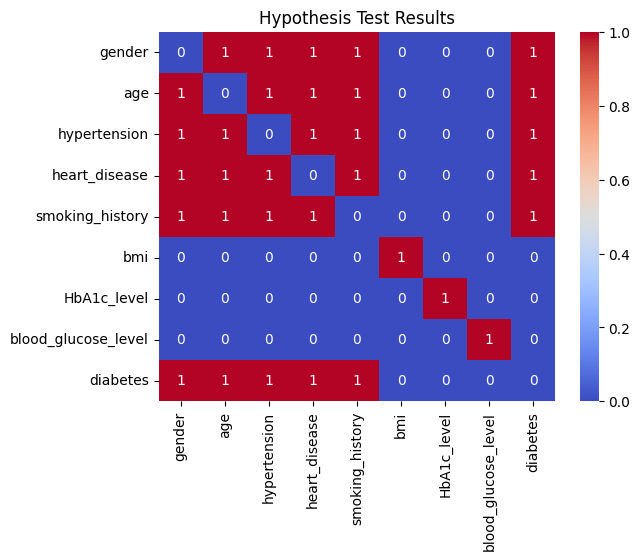

In [21]:
# Create a heatmap
sns.heatmap(comperativeColumn_result == 'There is a relationship', annot=True, cmap='coolwarm')
plt.title('Hypothesis Test Results')
plt.show()

# **Data Visualization**

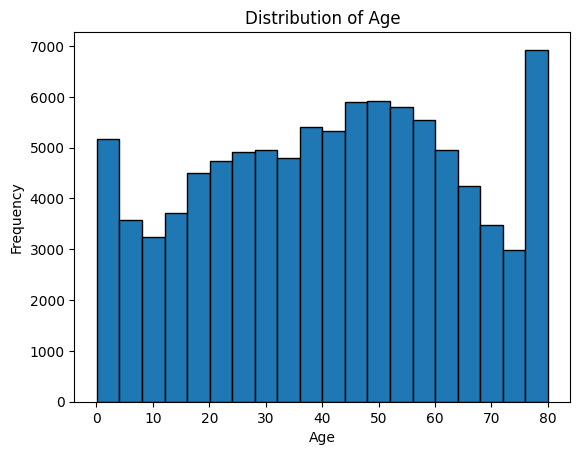

In [24]:
plt.hist(df['age'], bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()


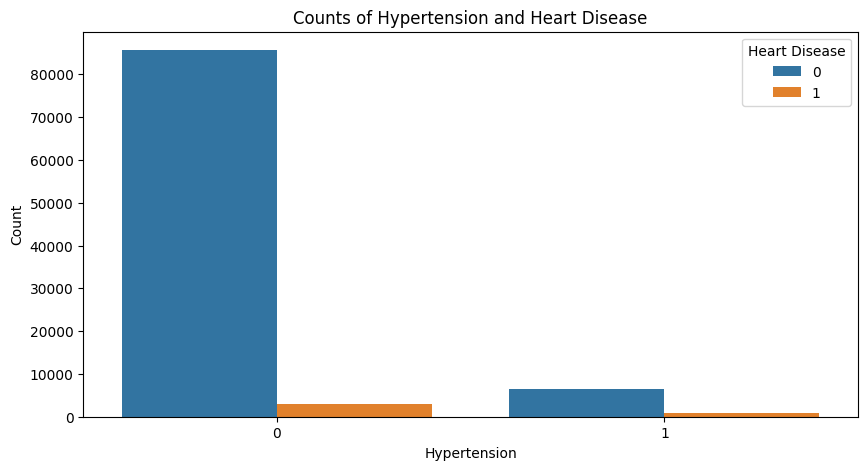

In [25]:
plt.figure(figsize=(10, 5))
sns.countplot(x='hypertension', hue='heart_disease', data=df)
plt.xlabel('Hypertension')
plt.ylabel('Count')
plt.title('Counts of Hypertension and Heart Disease')
plt.legend(title='Heart Disease', loc='upper right')
plt.show()

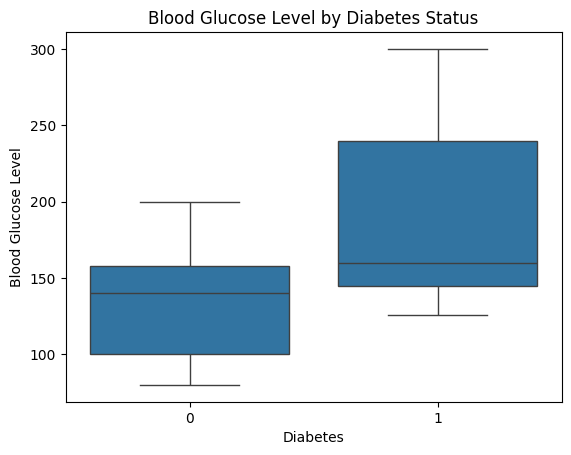

In [27]:
sns.boxplot(x='diabetes', y='blood_glucose_level', data=df)
plt.xlabel('Diabetes')
plt.ylabel('Blood Glucose Level')
plt.title('Blood Glucose Level by Diabetes Status')
plt.show()

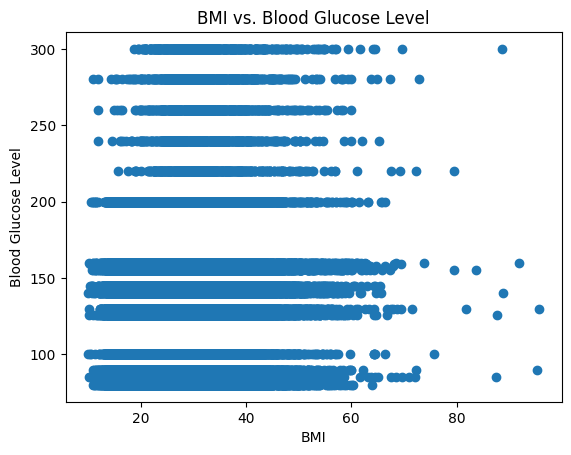

In [30]:
plt.scatter(df['bmi'], df['blood_glucose_level'])
plt.xlabel('BMI')
plt.ylabel('Blood Glucose Level')
plt.title('BMI vs. Blood Glucose Level')
plt.show()

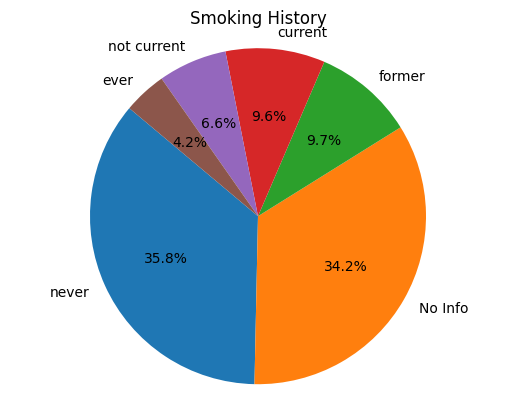

In [31]:
smoking_counts = df['smoking_history'].value_counts()
plt.pie(smoking_counts, labels=smoking_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Smoking History')
plt.axis('equal')
plt.show()

# **Preprocessing**

In [32]:
# Replacing categorical values with numerical equivalents
encode=OrdinalEncoder()
df.gender=encode.fit_transform(df[["gender"]])
df.smoking_history=encode.fit_transform(df[["smoking_history"]])

# **Machine Learning**

In [ ]:
# 1 data availability
# 2 separating independent and dependent
# 3 identifying algorithms/Model
# 4 training
# 5 evaluation

In [33]:
# 2 separating independent and dependent
x=df.drop("diabetes",axis=1)
y=df["diabetes"]

In [34]:
# 3 identifying algorithms/Model - GradientBoostingClassifier
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)

In [35]:
# 4 training
model=GradientBoostingClassifier().fit(x_train,y_train)
y_pred=model.predict(x_test)
accuracy_score(y_test,y_pred)

0.971918292632192

In [38]:
# 5 evaluation
input = np.array([[0, 56, 0, 1, 3, 26.7, 5.6, 170]])
prediction = model.predict(input)
prediction

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names



array([0])